In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)

In [3]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [4]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

In [5]:
in_features = 25
out_features = 12
block = get_generator_block(in_features, out_features)
block

Sequential(
  (0): Linear(in_features=25, out_features=12, bias=True)
  (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
)

In [6]:
len(block)

3

In [7]:
type(block[0]) == nn.Linear

True

In [8]:
type(block[1]) == nn.BatchNorm1d

True

In [9]:
type(block[2]) == nn.ReLU

True

In [10]:
test_input = torch.randn(1000, in_features)
test_input.shape

torch.Size([1000, 25])

In [11]:
test_output = block(test_input)
test_output.shape

torch.Size([1000, 12])

In [12]:
test_output.std()

tensor(0.5848, grad_fn=<StdBackward0>)

In [13]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    
    def forward(self, noise):
        return self.gen(noise)
    
    def get_gen(self):
        return self.gen

In [14]:
gen = Generator()
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [15]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [16]:
get_noise(10, 5)

tensor([[ 0.1084,  1.0805, -0.2469,  0.5607, -0.2189],
        [ 0.0032, -0.1771,  0.5921, -0.5654,  0.1721],
        [-0.6791, -0.3943, -0.5654,  1.1289, -1.4885],
        [-1.8797,  0.0623,  0.8160, -1.0010,  1.6710],
        [-0.3169,  0.7228, -1.2132, -0.6737, -1.0576],
        [ 0.1110, -0.2236, -1.0769,  0.5935,  0.2120],
        [-0.3127,  1.4029,  1.4516,  1.7070,  0.7550],
        [-0.7126,  0.1302,  0.7974,  0.6999, -0.2352],
        [ 0.4537,  1.6746,  1.7300, -0.7592,  1.3088],
        [-0.3902, -0.9238,  0.6709, -0.2787, -1.1083]])

In [17]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2)
    )

In [18]:
block = get_discriminator_block(25, 12)
block

Sequential(
  (0): Linear(in_features=25, out_features=12, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
)

In [19]:
class Discriminator(nn.Module):
    def __init__(self, in_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(in_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, image):
        return self.disc(image)

    def get_disc(self):
        return self.disc

In [20]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

In [21]:
dataset = MNIST('.', download=True, transform=transforms.ToTensor())

In [22]:
dataset[0][0].shape

torch.Size([1, 28, 28])

In [23]:
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

In [24]:
device = 'cuda:1'

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [25]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    noise = get_noise(num_images, z_dim).to(device)
    fake = gen(noise)
    y_hat = disc(fake.detach())
    d_loss_fake = criterion(y_hat, torch.zeros_like(y_hat))

    y_hat = disc(real)
    d_loss_real = criterion(y_hat, torch.ones_like(y_hat))
    
    disc_loss = (d_loss_fake + d_loss_real) / 2
    
    return disc_loss

In [26]:
z_dim = 64
num_images = 10
real = torch.ones(num_images, 784, device='cuda:1')
disc_loss = get_disc_loss(gen, disc, criterion, real, num_images, z_dim, 'cuda:1')
print(disc_loss)

tensor(0.6881, device='cuda:1', grad_fn=<DivBackward0>)


In [27]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    noise = get_noise(num_images, z_dim).to(device)
    fake = gen(noise)
    y_hat = disc(fake)
    # Generatorはfakeがrealと判定してほしいのでtargetは1にする
    gen_loss = criterion(y_hat, torch.ones_like(y_hat))
    return gen_loss

In [28]:
num_images = 10
z_dim = 64
get_gen_loss(gen, disc, criterion, num_images, z_dim, 'cuda:1')

tensor(0.6406, device='cuda:1', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

Epoch 1, step 500: Generator loss: 1.3373844505548476, discriminator loss: 0.4264254233837126


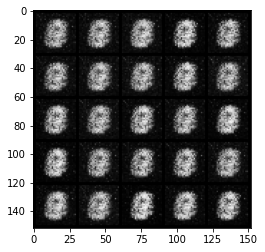

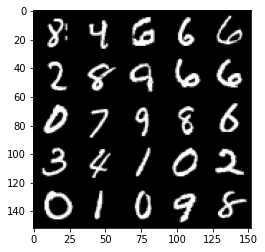

Epoch 2, step 1000: Generator loss: 1.676581856727601, discriminator loss: 0.2928468792438509


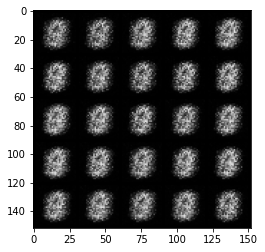

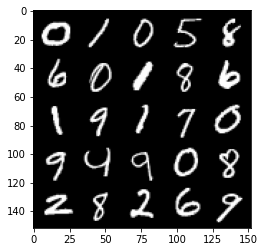

Epoch 3, step 1500: Generator loss: 1.858380899906158, discriminator loss: 0.19064895457029346


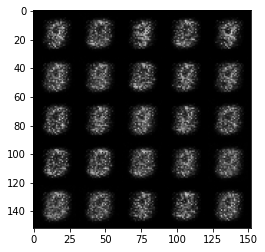

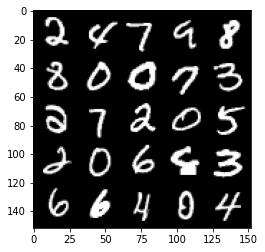

Epoch 4, step 2000: Generator loss: 1.6010694825649254, discriminator loss: 0.2287458893060683


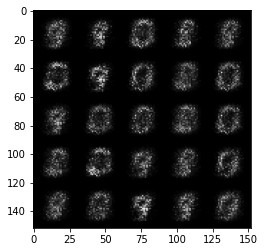

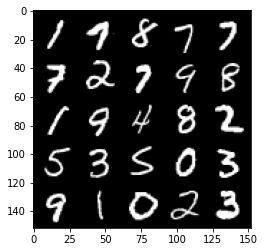

Epoch 5, step 2500: Generator loss: 1.6864157600402834, discriminator loss: 0.19251209264993638


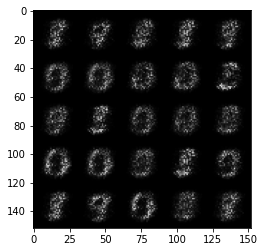

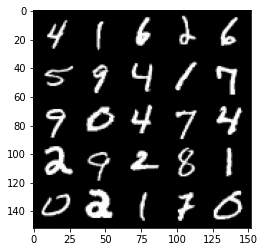

Epoch 6, step 3000: Generator loss: 2.048776536941528, discriminator loss: 0.1483153694421053


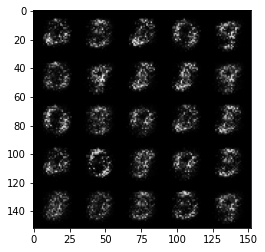

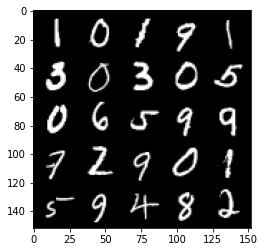

Epoch 7, step 3500: Generator loss: 2.421500763893126, discriminator loss: 0.12675558695197106


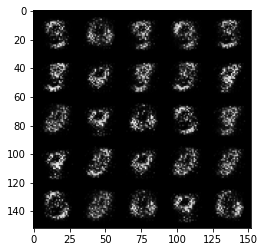

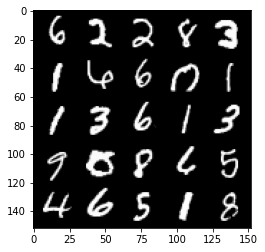

Epoch 8, step 4000: Generator loss: 2.837717192649841, discriminator loss: 0.10484738014638423


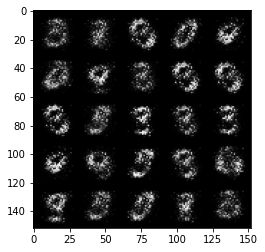

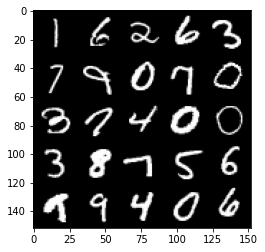

Epoch 9, step 4500: Generator loss: 3.1736100316047633, discriminator loss: 0.09419871995598078


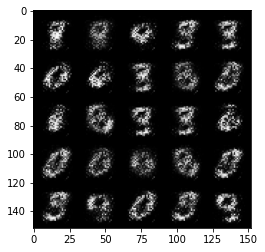

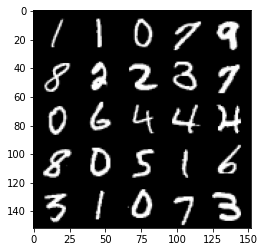

Epoch 10, step 5000: Generator loss: 3.3694433941841124, discriminator loss: 0.08938976740092033


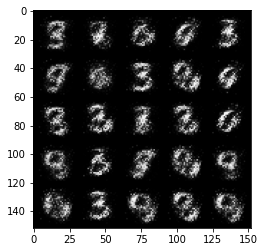

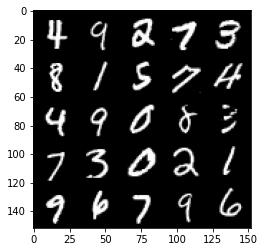

Epoch 11, step 5500: Generator loss: 3.637863493919374, discriminator loss: 0.07556392934173341


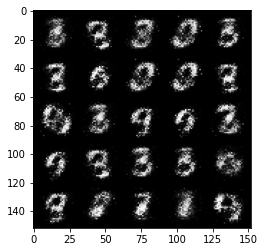

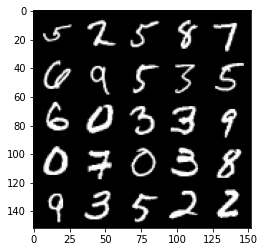

Epoch 12, step 6000: Generator loss: 3.771492897033689, discriminator loss: 0.06878174640983341


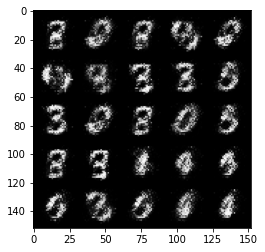

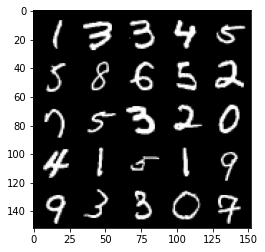

Epoch 13, step 6500: Generator loss: 3.832141952991487, discriminator loss: 0.05597943020611998


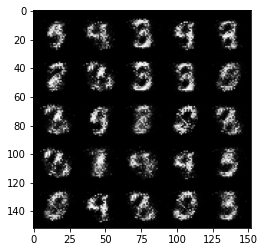

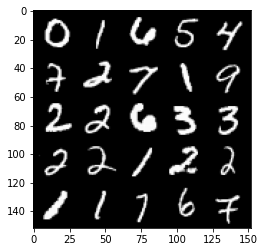

Epoch 14, step 7000: Generator loss: 3.911898876667026, discriminator loss: 0.059085892517119654


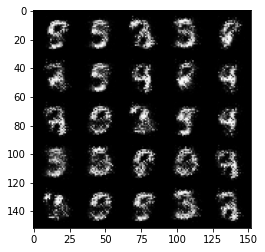

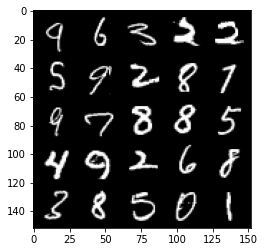

Epoch 15, step 7500: Generator loss: 3.835924861907959, discriminator loss: 0.06597464850544926


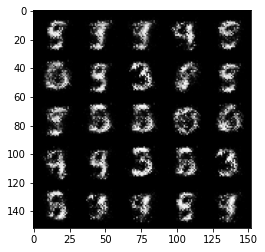

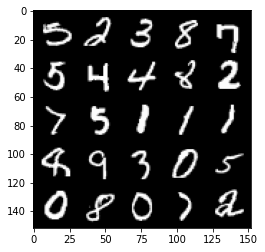

Epoch 17, step 8000: Generator loss: 4.048854497909546, discriminator loss: 0.06252517486363647


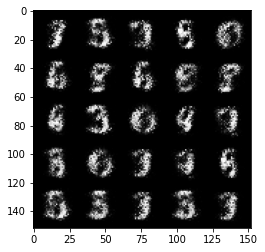

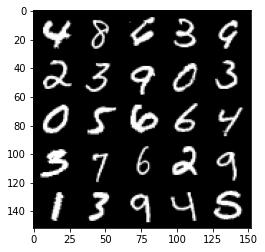

Epoch 18, step 8500: Generator loss: 4.068920573234561, discriminator loss: 0.061131172217428746


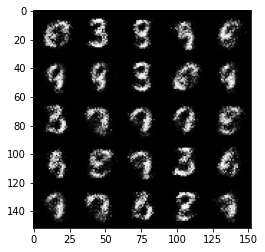

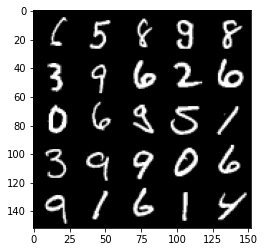

Epoch 19, step 9000: Generator loss: 4.030322366714482, discriminator loss: 0.06892546741664404


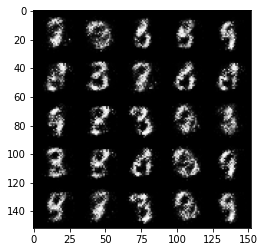

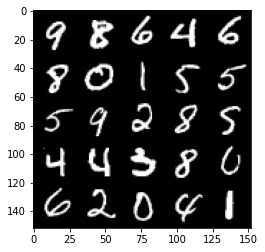

Epoch 20, step 9500: Generator loss: 4.059693514347076, discriminator loss: 0.06325936634093521


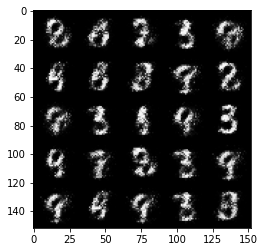

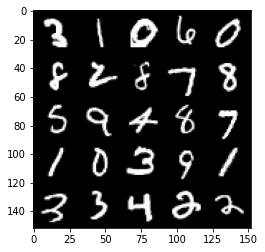

Epoch 21, step 10000: Generator loss: 4.240570015430445, discriminator loss: 0.0524873541295528


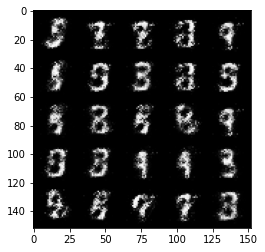

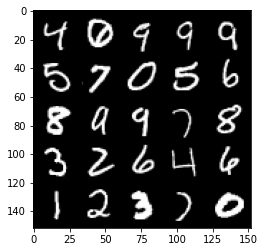

Epoch 22, step 10500: Generator loss: 4.10614530181885, discriminator loss: 0.05925702555105088


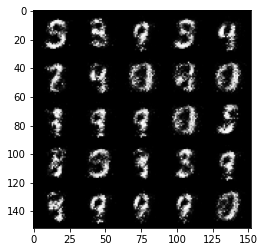

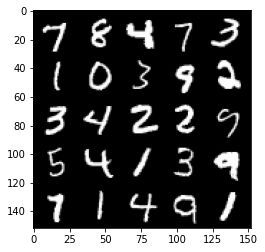

Epoch 23, step 11000: Generator loss: 4.195347662925715, discriminator loss: 0.06814290148764843


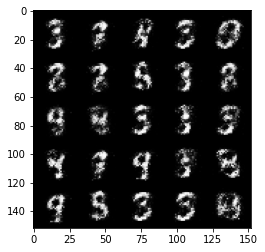

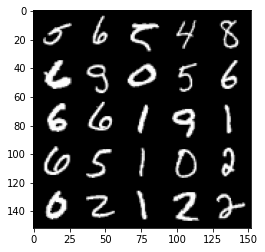

Epoch 24, step 11500: Generator loss: 3.9823762459754932, discriminator loss: 0.06815736083686347


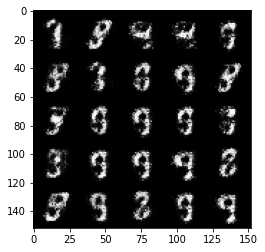

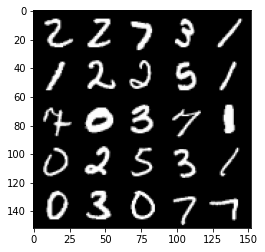

Epoch 25, step 12000: Generator loss: 4.192316725254057, discriminator loss: 0.061134688992053314


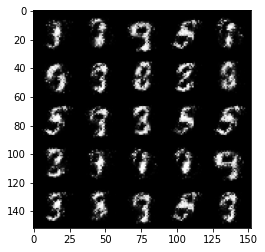

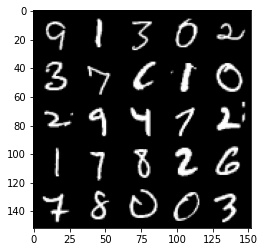

Epoch 26, step 12500: Generator loss: 4.374529245376591, discriminator loss: 0.06240315164625647


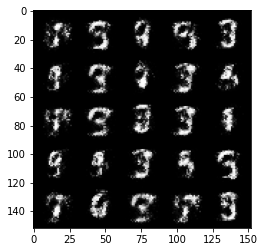

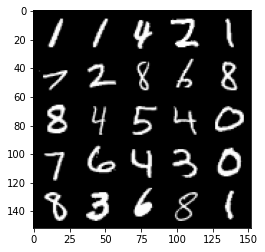

Epoch 27, step 13000: Generator loss: 4.3554662938118005, discriminator loss: 0.06478637543693183


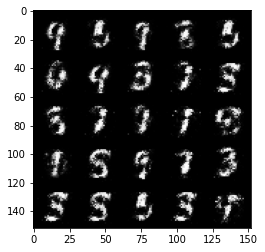

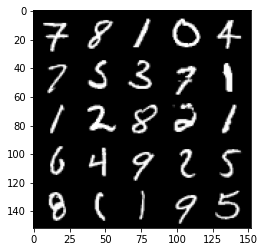

Epoch 28, step 13500: Generator loss: 3.906587468147275, discriminator loss: 0.08281584315747019


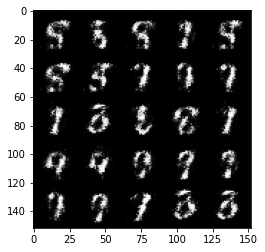

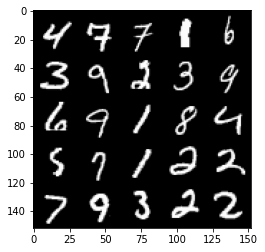

Epoch 29, step 14000: Generator loss: 4.126467716693878, discriminator loss: 0.074509913854301


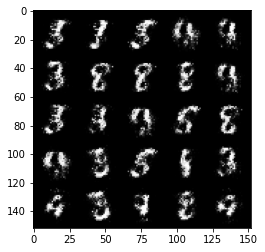

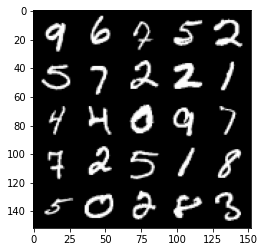

Epoch 30, step 14500: Generator loss: 4.091849220275874, discriminator loss: 0.0789511970803141


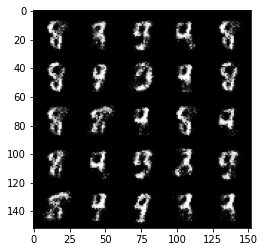

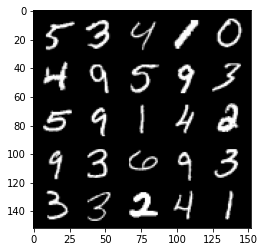

Epoch 31, step 15000: Generator loss: 3.852196841239929, discriminator loss: 0.08758576291799557


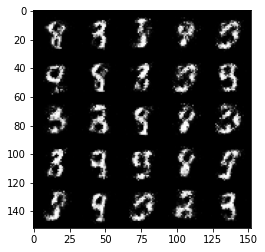

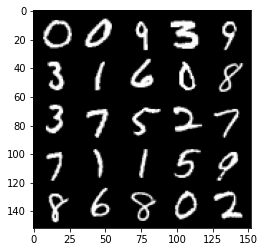

Epoch 33, step 15500: Generator loss: 4.084415335178373, discriminator loss: 0.08043493924289938


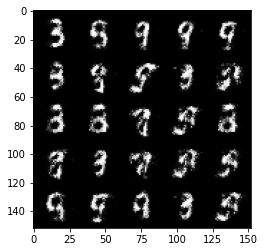

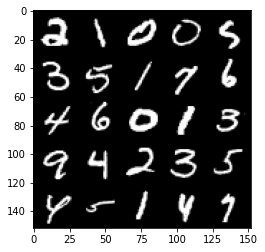

Epoch 34, step 16000: Generator loss: 3.939092734813694, discriminator loss: 0.08331091143935922


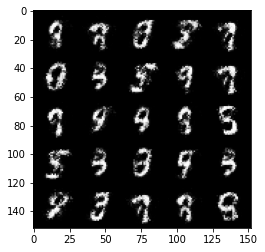

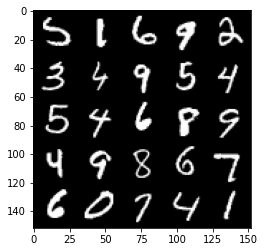

Epoch 35, step 16500: Generator loss: 3.8399493050575266, discriminator loss: 0.10118566055595872


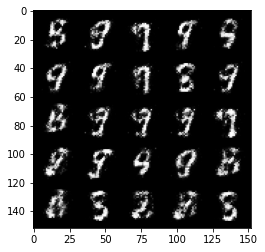

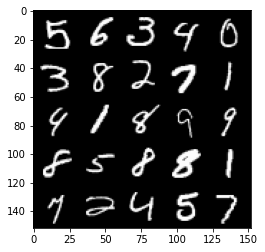

Epoch 36, step 17000: Generator loss: 3.6624673147201476, discriminator loss: 0.10869336319714777


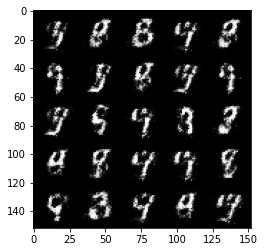

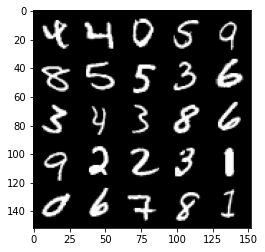

Epoch 37, step 17500: Generator loss: 3.7274841794967655, discriminator loss: 0.11513487016409635


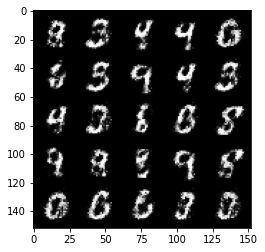

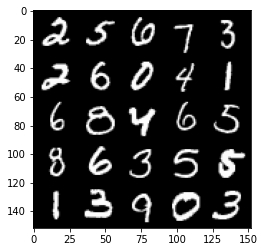

Epoch 38, step 18000: Generator loss: 3.7781366257667526, discriminator loss: 0.10880509115755571


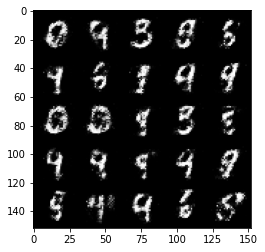

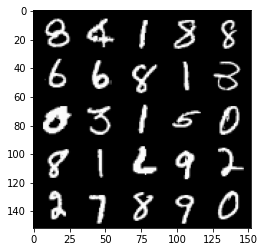

Epoch 39, step 18500: Generator loss: 3.5404919137954716, discriminator loss: 0.12689067727327338


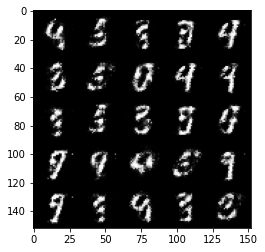

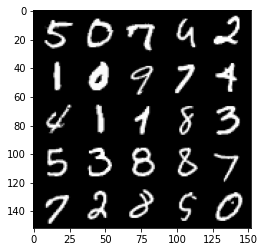

Epoch 40, step 19000: Generator loss: 3.479864239215853, discriminator loss: 0.13533064337074757


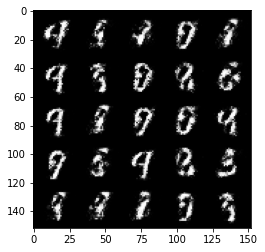

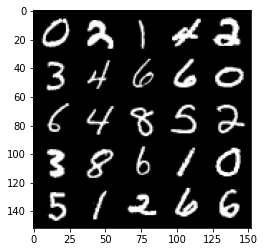

Epoch 41, step 19500: Generator loss: 3.447737277030948, discriminator loss: 0.1430553513467312


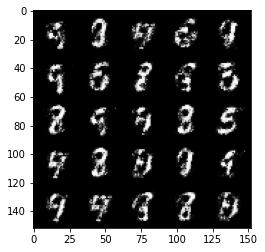

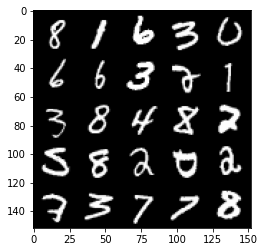

Epoch 42, step 20000: Generator loss: 3.392412734985354, discriminator loss: 0.1421166011542082


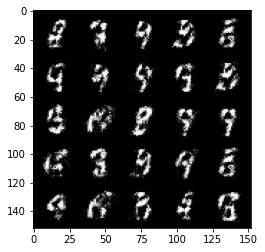

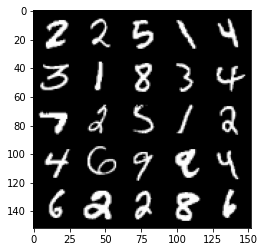

Epoch 43, step 20500: Generator loss: 3.389489577770235, discriminator loss: 0.1402106710672378


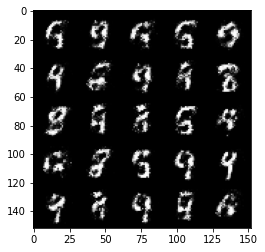

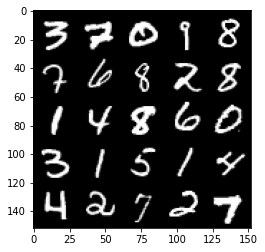

Epoch 44, step 21000: Generator loss: 3.4538477096557645, discriminator loss: 0.13652383954823022


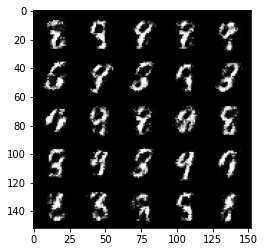

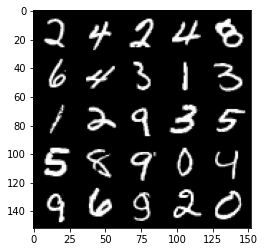

Epoch 45, step 21500: Generator loss: 3.352269998073577, discriminator loss: 0.15363493014872062


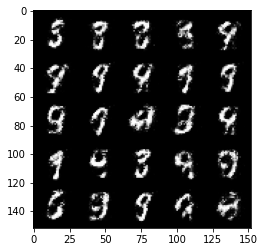

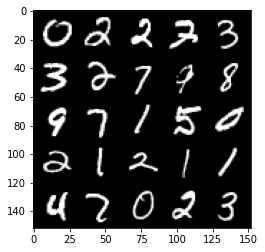

Epoch 46, step 22000: Generator loss: 3.3150597548484844, discriminator loss: 0.15279113371670233


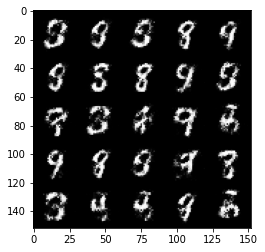

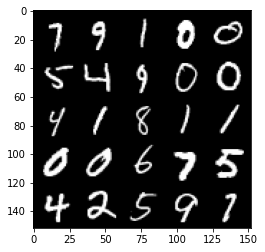

Epoch 47, step 22500: Generator loss: 3.230848441123962, discriminator loss: 0.17263694486021983


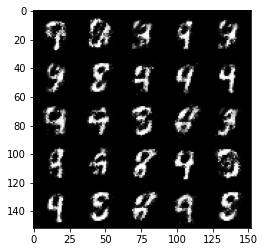

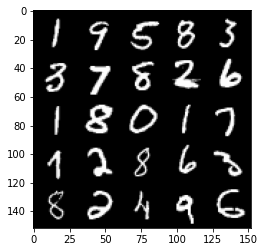

Epoch 49, step 23000: Generator loss: 3.0027212662696834, discriminator loss: 0.18178207601606852


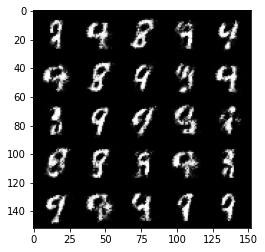

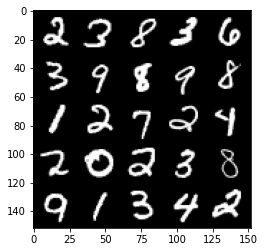

Epoch 50, step 23500: Generator loss: 2.9703043260574336, discriminator loss: 0.1784706597030162


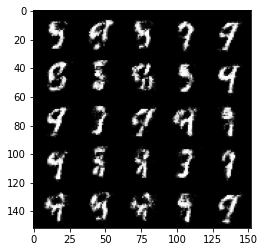

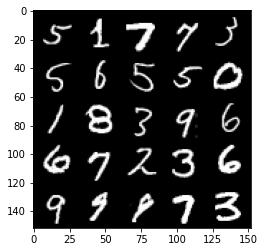

Epoch 51, step 24000: Generator loss: 3.007397655963898, discriminator loss: 0.17808616332709773


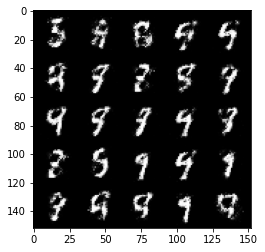

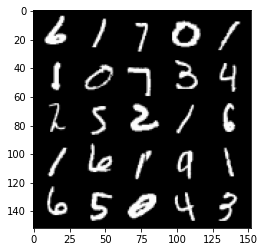

Epoch 52, step 24500: Generator loss: 3.1224817423820475, discriminator loss: 0.17397186484932903


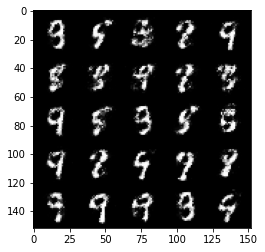

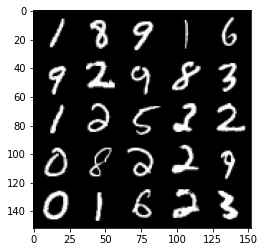

Epoch 53, step 25000: Generator loss: 2.918775378704073, discriminator loss: 0.1754228113740681


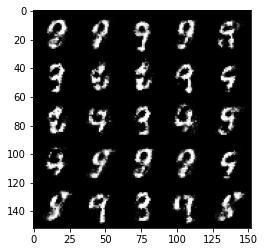

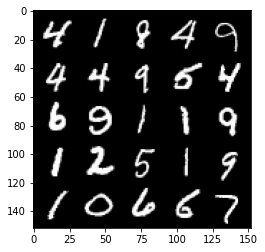

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        
        real = real.squeeze(1).view(cur_batch_size, -1).to(device)

        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
       
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step
        
        if cur_step % display_step == 0 and cur_step > 0:
            print(f'Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}')
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        
        cur_step += 1